# Playing with the model outocomes - §§patial Analysis

You need to run the model at least one time to create the snapshot files requeried.

In [1]:
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import matplotlib.pyplot as plt

from coding.model.opencl.ramp.run import run_headless
from coding.model.opencl.ramp.run import run_opencl
from coding.model.opencl.ramp.snapshot_convertor import SnapshotConvertor
from coding.model.opencl.ramp.snapshot import Snapshot
from coding.model.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from coding.initialise.initialisation_cache import InitialisationCache
from coding.model.opencl.ramp.simulator import Simulator
from coding.model.opencl.ramp.disease_statuses import DiseaseStatus


from coding.model.opencl.ramp.run import run_opencl
from coding.constants import Constants

# Useful for connecting to this kernel
#%connect_info


In [2]:

os.chdir('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709')
os.getcwd()

'/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709'

### Reading the parameters file and requeried parameters

In [5]:
parameters_file = "/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/model_parameters/default.yml"    
try:
    with open(parameters_file, 'r') as f:
        parameters = yaml.load(f,Loader=yaml.SafeLoader)
        sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
        calibration_params = parameters["microsim_calibration"]
        disease_params = parameters["disease"]  # Parameters for the disease model (r)
        #scenario = sim_params["scenario"]
        #initialise = sim_params["initialise"]
        iterations = 120
        study_area = sim_params["study-area"]
        list_of_msoas_file = sim_params["list-of-msoas"]
        # selected_region_folder_name = sim_params["selected-region-folder-name"]
        #output = sim_params["output"]
        #output_every_iteration = sim_params["output-every-iteration"]
        #debug = sim_params["debug"]
        repetitions = 10
        #use_lockdown = sim_params["use-lockdown"]
        # quant_dir = sim_params["quant-dir"]
        use_cache = sim_params["use-cache"]
        open_cl_model = sim_params["opencl-model"]
        opencl_gui = False
        opencl_gpu = sim_params["opencl-gpu"]
        startDate = sim_params["start-date"]
except Exception as error:
    print('Error in parameters file format')
    raise error

### Function to create the requeried parameters based on the parameters file

In [6]:
def create_params(calibration_params, disease_params):
    current_risk_beta = disease_params["current_risk_beta"]

    # NB: OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
    location_hazard_multipliers = LocationHazardMultipliers(
        retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
        nightclubs=calibration_params["hazard_location_multipliers"]["Nightclubs"] * current_risk_beta,
        primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
        secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
        home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
        work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
    )

    individual_hazard_multipliers = IndividualHazardMultipliers(
        presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
        asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
        symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
    )

    obesity_multipliers = [disease_params["overweight"], disease_params["obesity_30"], disease_params["obesity_35"],
                           disease_params["obesity_40"]]

    return Params(
        location_hazard_multipliers=location_hazard_multipliers,
        individual_hazard_multipliers=individual_hazard_multipliers,
        obesity_multipliers=obesity_multipliers,
        cvd_multiplier=disease_params["cvd"],
        diabetes_multiplier=disease_params["diabetes"],
        bloodpressure_multiplier=disease_params["bloodpressure"],
    )

In [7]:
def run_opencl_model2(i, iterations,
                     use_gpu,
                     calibration_params,
                     disease_params,
                     parameters_file,
                     store_detailed_counts=True):
                     
    study_area_folder_in_processed_data = ('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/processed_data/WY') 
    snapshot_cache_filepath = os.path.join(study_area_folder_in_processed_data, "snapshot", "cache.npz")
    #print(f"\n the snapshot we read is located {snapshot_cache_filepath}")
    snapshot = Snapshot.load_full_snapshot(path=snapshot_cache_filepath)

    # set the random seed of the model
    snapshot.seed_prngs(i)

    # set params
    if calibration_params is not None and disease_params is not None:
        snapshot.update_params(create_params(calibration_params, disease_params))

        if disease_params["improve_health"]:
            print("Switching to healthier population")
            snapshot.switch_to_healthier_population()

    simulator = Simulator(snapshot,
                          parameters_file,
                          gpu=use_gpu
                          )
    
    [people_statuses,people_transition_times] = simulator.seeding_base()

    simulator.upload_all(snapshot.buffers)
    
    simulator.upload("people_statuses", people_statuses)
    simulator.upload("people_transition_times", people_transition_times)
    
       
    run_mode = "headless"

    #print(f"\nRunning OpenCL model in {run_mode} mode")
    print(f"Running simulation {i+1}.")
    
    """"
    run_opencl(snapshot,
               study_area,
               parameters_file,
               iterations,
               use_gpu,
               quiet=False
               )
    """
    summary, final_state = run_headless(simulator,
                 snapshot,
                 iterations,
                 quiet=True,
                 store_detailed_counts=store_detailed_counts)
    
    
    return summary, final_state

## Run the similation 10 times, based on the requerired parameters (Funtion based on main_model.pv)

In [8]:
summaries = []
final_results = []

# Prepare the function arguments as lists for starmap

l_i = [i for i in range(repetitions)]
#l_individuals = [individuals] * repetitions
#l_activity_locations = [activity_locations] * repetitions
l_iterations = [iterations] * repetitions
#l_study_area = [study_area] * repetitions
#l_opencl_gui = [opencl_gui] * repetitions
l_opencl_gpu =[opencl_gpu] * repetitions
l_calibration_params = [calibration_params] * repetitions
l_disease_params =[disease_params] * repetitions
l_parameters_file =[parameters_file] * repetitions

results = itertools.starmap( run_opencl_model2, zip(
                l_i,
                #l_individuals,
                #l_activity_locations,
                l_iterations,
                #l_study_area,
                #l_opencl_gui,
                l_opencl_gpu,
                l_calibration_params,
                l_disease_params,
                l_parameters_file))
summaries = [x[0] for x in results]
final_results = [x[1] for x in results]

Running simulation 1.
Running simulation 2.
Running simulation 3.
Running simulation 4.
Running simulation 5.
Running simulation 6.
Running simulation 7.
Running simulation 8.
Running simulation 9.
Running simulation 10.


## Plot the results from the integrated simulations

In [9]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

### Plot of variability from the similated escenarios for each disease status

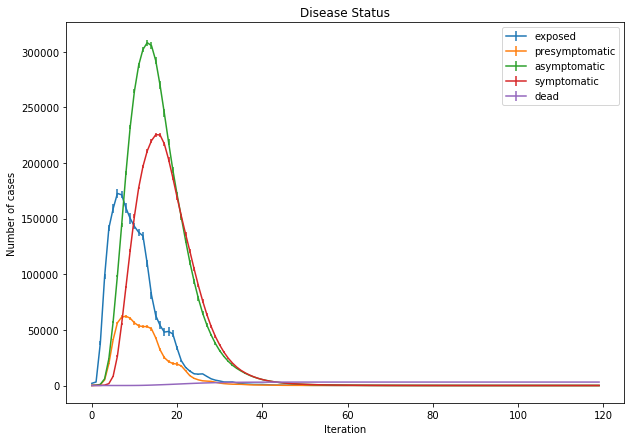

In [10]:
plot_summaries(summaries=summaries, plot_type="error_bars")

In [11]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

### Disease status per Age

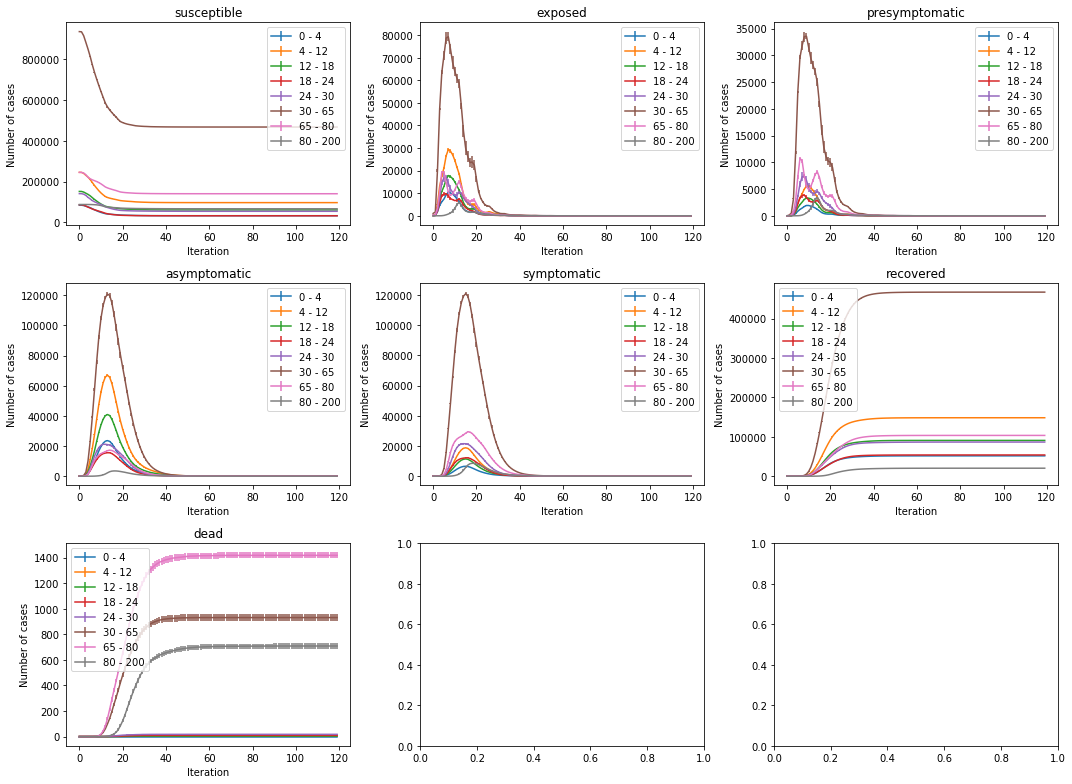

In [12]:
plot_disease_status_by_age(summaries)

## Now more Geographical representation, based on the study area

In [13]:
shapefile = ('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/raw_data/national_data/MSOAS_shp/msoas.shp')
list_of_msoas = os.path.join(Constants.Paths.PARAMETERS.FULL_PATH, list_of_msoas_file)
list_of_msoas, shapefile

('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/model_parameters/WY_MSOAs_CasesPerDay24.csv',
 '/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/raw_data/national_data/MSOAS_shp/msoas.shp')

In [14]:
import geopandas as gpd
from coding.initialise.raw_data_handler import RawDataHandler
from coding.initialise.load_msoa_locations import MapsHandler
def load_osm_shapefile(data_dir):
    shape_file = os.path.join(data_dir, "gis_osm_buildings_a_free_1.shp")
    print("Loading OSM buildings shapefile")
    osm_buildings = gpd.read_file(shape_file)
    print(f"Loaded {len(osm_buildings.index)} buildings from shapefile")
    return osm_buildings

In [15]:
data_dir = ('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/raw_data/county_data/OSM/west-yorkshire')
WY_buildings = load_osm_shapefile(data_dir)

Loading OSM buildings shapefile
Loaded 457030 buildings from shapefile


In [16]:
from coding.initialise.load_msoa_locations import MapsHandler
from coding.constants import ColumnNames
import pandas as pd

def load_studyarea_msoas(msoa_list_with_path):
    return pd.read_csv(msoa_list_with_path, usecols=[ColumnNames.MSOAsID]) #["MSOA11CD"])

def load_msoa_shapes(shapefile, msoa_list_with_path, visualize=False):
        # shape_dir = os.path.join(data_dir, "MSOAS_shp")
        # shape_file = os.path.join(shape_dir, "bcc21fa2-48d2-42ca-b7b7-0d978761069f2020412-1-12serld.j1f7i.shp")
        shape_file = shapefile
        all_msoa_shapes = gpd.read_file(shape_file)
        all_msoa_shapes = all_msoa_shapes.rename(columns={"msoa11cd":ColumnNames.MSOAsID}) #"MSOA11CD"})
        print(f"Loaded {len(all_msoa_shapes.index)} MSOA shapes with projection {all_msoa_shapes.crs}")

        # re-project coordinates from british national grid to WGS84 (lat/lon)
        all_msoa_shapes = all_msoa_shapes.to_crs("EPSG:4326")

        # Filter to the study area's MSOAs
        studyarea_msoas = load_studyarea_msoas(msoa_list_with_path) #(data_dir)
        print(f"Loaded {len(studyarea_msoas.index)} study area MSOA codes")

        studyarea_msoa_shapes = pd.merge(all_msoa_shapes,
                                         studyarea_msoas,
                                         on=ColumnNames.MSOAsID) #"MSOA11CD")
        print(f"Filtered {len(studyarea_msoa_shapes.index)} study area MSOA shapes")

        if visualize:
            studyarea_msoa_shapes.plot()
            plt.show()

        return studyarea_msoa_shapes

## MSOA areas in WestYorkshire area.

Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 299 study area MSOA codes
Filtered 299 study area MSOA shapes


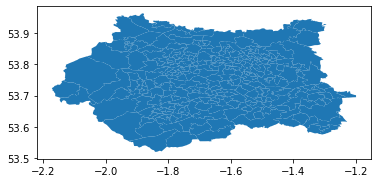

In [17]:
WY_msoa_shapes = load_msoa_shapes(shapefile,list_of_msoas,visualize=True)

In [18]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    msoa_data_for_status = msoa_data[disease_status]
    # add "Code" column so dataframes can be merged
    msoa_data_for_status['Code'] = msoa_data_for_status.index
    msoa_shapes['Code'] = msoa_shapes['MSOA11CD']
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on='Code')
    msoa_shapes.plot(column=f"Day{timestep}", legend=True, figsize=(16, 6))
    plt.show()


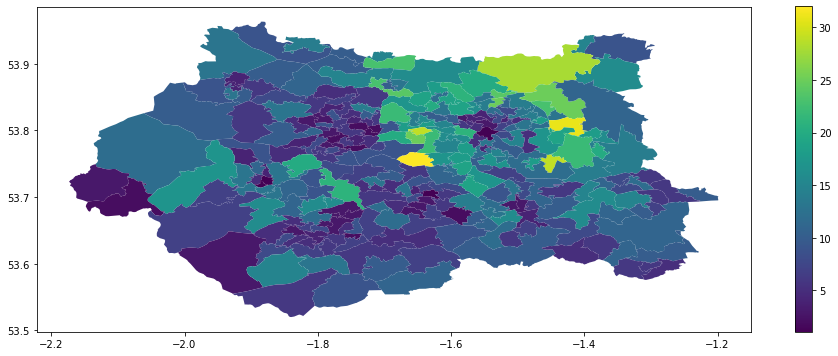

In [33]:
disease_status = 'dead' #recovered, susceptible, exposed, presymptomatic, asymptomatic, symptomatic
plot_msoa_choropleth(WY_msoa_shapes, summaries[0], disease_status, 99) #99 represent the day of the simulation. Summary[5] the simulated escenario

# More interactive outcomes with the disease status  

In [112]:
import geopandas as gpd
from shapely.geometry import Point
import hvplot.pandas  # noqa
from bokeh.models import CustomJS, Slider
from bokeh.models import CustomJS, Slider
from bokeh.io import output_notebook, show
from holoviews.plotting.links import DataLink
from holoviews import opts

output_notebook()

Loading BokehJS ...

In [63]:
msoa_data = summaries[0].get_area_dataframes()
msoa_data_for_status = msoa_data[disease_status]
# add "Code" column so dataframes can be merged
msoa_data_for_status['Code'] = msoa_data_for_status.index
WY_msoa_shapes['Code'] = WY_msoa_shapes['MSOA11CD']
WY_msoa_shapes2 = pd.merge(WY_msoa_shapes, msoa_data_for_status, on='Code')

In [119]:
list(WY_msoa_shapes2)

['MSOA11CD',
 'objectid',
 'MSOA11NM',
 'MSOA11NMW',
 'st_area',
 'st_length',
 'district',
 'pop_densit',
 'connectivi',
 'qimd',
 'risk',
 'pop',
 'lng',
 'lat',
 'geometry',
 'Code',
 'Day0',
 'Day1',
 'Day2',
 'Day3',
 'Day4',
 'Day5',
 'Day6',
 'Day7',
 'Day8',
 'Day9',
 'Day10',
 'Day11',
 'Day12',
 'Day13',
 'Day14',
 'Day15',
 'Day16',
 'Day17',
 'Day18',
 'Day19',
 'Day20',
 'Day21',
 'Day22',
 'Day23',
 'Day24',
 'Day25',
 'Day26',
 'Day27',
 'Day28',
 'Day29',
 'Day30',
 'Day31',
 'Day32',
 'Day33',
 'Day34',
 'Day35',
 'Day36',
 'Day37',
 'Day38',
 'Day39',
 'Day40',
 'Day41',
 'Day42',
 'Day43',
 'Day44',
 'Day45',
 'Day46',
 'Day47',
 'Day48',
 'Day49',
 'Day50',
 'Day51',
 'Day52',
 'Day53',
 'Day54',
 'Day55',
 'Day56',
 'Day57',
 'Day58',
 'Day59',
 'Day60',
 'Day61',
 'Day62',
 'Day63',
 'Day64',
 'Day65',
 'Day66',
 'Day67',
 'Day68',
 'Day69',
 'Day70',
 'Day71',
 'Day72',
 'Day73',
 'Day74',
 'Day75',
 'Day76',
 'Day77',
 'Day78',
 'Day79',
 'Day80',
 'Day81',
 'Da

In [127]:
scatter1=WY_msoa_shapes2.hvplot(title=f'Number of dead per MSOA in WestYorkshire',
           geo=True,
           c="Day110",
           tiles='CartoLight', #'CartoDark', 'CartoEco', 'CartoLight', 'CartoMidnight', 'EsriImagery', 'EsriNatGeo', 'EsriReference', 'EsriStreet', 'EsriTerrain', 'EsriUSATopo', 'OSM', 'StamenLabels', 'StamenLabelsRetina', 'StamenTerrain', 'StamenTerrainRetina', 'StamenToner', 'StamenTonerBackground', 'StamenTonerBackgroundRetina', 'StamenTonerRetina', 'StamenWatercolor', 'Wikipedia'
           frame_width=600,
           frame_height=400)

scatter2= WY_msoa_shapes2.hvplot(title=f'Population Density per MSOA in WestYorkshire',
           geo=True,
           c="pop_densit",
           tiles='CartoLight',
           cmap='YlGn',
           frame_width=600,
           frame_height=400)

scatter3= WY_msoa_shapes2.hvplot(title=f'Connectivity per MSOA in WestYorkshire',
           geo=True,
           c="connectivi",
           tiles='CartoLight',
           cmap='YlGn',
           frame_width=600,
           frame_height=400)

In [129]:
dlink = DataLink(scatter1, scatter2)

In [133]:
(scatter1 + scatter2).opts(opts.Scatter(tools=['box_select', 'lasso_select', 'hover']))

:Layout
   .Overlay.I  :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Polygons.I :Polygons   [Longitude,Latitude]   (Day110)
   .Overlay.II :Overlay
      .Tiles.I    :Tiles   [x,y]
      .Polygons.I :Polygons   [Longitude,Latitude]   (pop_densit)

### Down from here, I have just experiments, do not take it seriously. 

In [65]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [66]:
x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)


In [67]:
p = figure(title="simple line example", height=300, width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

In [142]:
def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

In [143]:
show(p, notebook_handle=True)


In [144]:
interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))


interactive(children=(Dropdown(description='f', options=('sin', 'cos'), value='sin'), IntSlider(value=1, descr…

<function __main__.update(f, w=1, A=1, phi=0)>

In [145]:
"""
An example demonstrating how to put together a cross-selector app based
on the Auto MPG dataset.
"""
import holoviews as hv
import panel as pn
import panel.widgets as pnw

from bokeh.sampledata.autompg import autompg

df = autompg.copy()

ORIGINS = ['North America', 'Europe', 'Asia']

# data cleanup
df.origin = [ORIGINS[x-1] for x in df.origin]

df['mfr'] = [x.split()[0] for x in df.name]
df.loc[df.mfr=='chevy', 'mfr'] = 'chevrolet'
df.loc[df.mfr=='chevroelt', 'mfr'] = 'chevrolet'
df.loc[df.mfr=='maxda', 'mfr'] = 'mazda'
df.loc[df.mfr=='mercedes-benz', 'mfr'] = 'mercedes'
df.loc[df.mfr=='toyouta', 'mfr'] = 'toyota'
df.loc[df.mfr=='vokswagen', 'mfr'] = 'volkswagen'
df.loc[df.mfr=='vw', 'mfr'] = 'volkswagen'
del df['name']

columns = sorted(df.columns)
discrete = [x for x in columns if df[x].dtype == object]
continuous = [x for x in columns if x not in discrete]
quantileable = [x for x in continuous if len(df[x].unique()) > 20]

x = pnw.Select(name='X-Axis', value='mpg', options=quantileable)
y = pnw.Select(name='Y-Axis', value='hp', options=quantileable)
size = pnw.Select(name='Size', value='None', options=['None'] + quantileable)
color = pnw.Select(name='Color', value='None', options=['None'] + quantileable)

@pn.depends(x.param.value, y.param.value, color.param.value, size.param.value) 
def create_figure(x, y, color, size):
    opts = dict(cmap='rainbow', width=800, height=600, line_color='black')
    if color != 'None':
        opts['color'] = color 
    if size != 'None':
        opts['size'] = hv.dim(size).norm()*20
    return hv.Points(df, [x, y], label="%s vs %s" % (x.title(), y.title())).opts(**opts)

widgets = pn.WidgetBox(x, y, color, size, width=200)

pn.Row(widgets, create_figure).servable('Cross-selector')

Row
    [0] WidgetBox(width=200)
        [0] Select(name='X-Axis', options=['accel', 'displ', ...], value='mpg')
        [1] Select(name='Y-Axis', options=['accel', 'displ', ...], value='hp')
        [2] Select(name='Color', options=['None', 'accel', ...], value='None')
        [3] Select(name='Size', options=['None', 'accel', ...], value='None')
    [1] ParamFunction(function)